### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータkを学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
#using Distributions
using MDToolbox

In [2]:
epoch_n = 1
ff_input_txt_filepath = "output.txt"#txtファイル
ff_output_txt_filepath = "output_after_train.txt"
traj_dir = "./outdir/epoch_$(epoch_n)/dihedral"
njobs = 5

5

### ポテンシャルエネルギー関数の定義

In [3]:
#二面角のポテンシャルの計算
function compute_dihedral_energy(theta, theta_zero, n, k)
    U = k * (1 + cos(n * theta - theta_zero))
    return U
end

compute_dihedral_energy (generic function with 1 method)

In [4]:
function ChainRulesCore.rrule(::typeof(compute_dihedral_energy), theta, theta_zero, n, k)
    U = k * (1 + cos(n * theta - theta_zero))
    
    function compute_dihedral_energy_pullback(dU)
        dtheta = -k * n * sin(n * theta - theta_zero) * dU
        dtheta_zero = k * sin(n * theta - theta_zero) * dU
        dn = -k * theta * sin(n * theta - theta_zero) * dU
        dk = 1 + cos(n * theta - theta_zero) * dU
        return NoTangent(), dtheta, dtheta_zero, dn, dk
    end
    return U, compute_dihedral_energy_pullback
end

In [5]:
#nステップ目のポテンシャルを計算
function sum_compute_dihedral_energy(theta, theta_zero_array, n_array, k_array)
    #U = 0
    #for i in 1:size(n_array, 1)
    #    U += compute_dihedral_energy(theta, theta_zero_array[i], n_array[i], k_array[i])
    #end
    U = reduce(+, [compute_dihedral_energy(theta, theta_zero_array[i], n_array[i], k_array[i]) for i in 1:size(n_array, 1)])
    return U
end

sum_compute_dihedral_energy (generic function with 1 method)

In [6]:
#二面角からFを計算
function compute_free_energy(phi_array, psi_array, beta,
        theta_zero_phi_array, n_phi_array, k_phi_array, theta_zero_psi_array, n_psi_array, k_psi_array)
    N = size(phi_array, 2)
    U = 0 
    #for i in 1:N
    #    U += (sum_compute_dihedral_energy(phi_array, theta_zero_phi_array, n_phi_array, k_phi_array) 
    #        + sum_compute_dihedral_energy(psi_array, theta_zero_psi_array, n_psi_array, k_psi_array))
    #end
    #for文で書くと勾配計算でエラーが起こるためリスト内包表記を用いる
    U_array = [(sum_compute_dihedral_energy(phi_array[i], theta_zero_phi_array, n_phi_array, k_phi_array) 
            + sum_compute_dihedral_energy(psi_array[i], theta_zero_psi_array, n_psi_array, k_psi_array)) for i in 1:N]
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [7]:
# exponential averaging
function compute_deltaF(phi_array, psi_array, beta, theta_zero_array, n_array, k_array, U_array) #パラメータは全てターゲットのもの,U_arrayはターゲットでないポテンシャルの配列
    N = size(phi, 2)
    U_target_array = [sum_compute_dihedral_energy(phi_array[i], theta_zero_array, n_array, k_array) + sum_compute_dihedral_energy(psi_array[i], theta_zero_array, n_array, k_array) for i in 1:N]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

## ffパラメータ

In [8]:
#file input
f = open(ff_input_txt_filepath, "r")
datalist = readlines(f)
close

close (generic function with 52 methods)

In [9]:
#input parameter
#phi parameter
theta_zero_phi = []
k_phi = []
n_phi = []

theta_zero_psi = []
k_psi = []
n_psi = []

current = "PHI"

#create phi parameter
for line in datalist
    if(line == "PHI_PARAMETER")
        continue
    #"PSI_PARAMETER"が現れたらcurrent->"PSI"
    elseif(line == "PSI_PARAMETER")
        current = "PSI"
        continue
    end
    
    #parameterを配列に格納していく
    #phiの更新
    if(current == "PHI")
        if(occursin(r"type.*", split(line)[1]))
            continue
        elseif(occursin(r"periodicity.*", split(line)[1]))
            push!(n_phi, parse(Float64, split(line)[2]))
        elseif(occursin(r"phase.*", split(line)[1]))
            push!(theta_zero_phi, parse(Float64, split(line)[2]))
        elseif(occursin(r"k.*", split(line)[1]))
            push!(k_phi, parse(Float64, split(line)[2]))
        else
            println("ERROR")
        end
    end

    #psiの更新
    if(current == "PSI")
        if(occursin(r"type.*", split(line)[1]))
            continue
        elseif(occursin(r"periodicity.*", split(line)[1]))
            push!(n_psi, parse(Float64, split(line)[2]))
        elseif(occursin(r"phase.*", split(line)[1]))
            push!(theta_zero_psi, parse(Float64, split(line)[2]))
        elseif(occursin(r"k.*", split(line)[1]))
            push!(k_psi, parse(Float64, split(line)[2]))
        else
            println("ERROR")
        end
    end
end

In [10]:
theta_zero_psi

11-element Vector{Any}:
 2.8080339837817268
 3.141592653589793
 3.141592653589793
 3.141592653589793
 3.141592653589793
 3.141592653589793
 1.5707963267948966
 1.5707963267948966
 1.5707963267948966
 1.5707963267948966
 1.5707963267948966

In [42]:
sum(k_phi)

5.461886378852249

In [43]:
sum(k_psi)

9.282360040318146

### データ入力

In [11]:
data_k = [] #data[i][1] = phi[i], data[i][2] = psi[i]
for i in 1:njobs
    path = joinpath(traj_dir, "traj$(i).txt")
    #file input
    f = open(path, "r")
    list = readlines(f)
    close

    data = []
    for j in 1:size(split.(list), 1)
        tmp =  parse.(Float64, split.(list)[j])
        push!(data, (tmp[1], tmp[2]))
    end
    push!(data_k, data)
end

In [12]:
data_k_copy = []
K = njobs
N = minimum(map(size, data_k))[1]

for i in 1:K
    push!(data_k_copy, data_k[i][1:N])
end
data_k_copy[1]
data_k = data_k_copy

5-element Vector{Any}:
 Any[(-0.9789619445800781, 2.1897201538085938), (-2.0090885162353516, 3.06614089012146), (-0.9607083201408386, 1.883558750152588), (-1.0503926277160645, 2.456561326980591), (-1.2437831163406372, -0.6946479082107544), (-1.1792792081832886, 1.7290538549423218), (-1.3580780029296875, -3.1049225330352783), (-1.329982042312622, 2.670448064804077), (-0.9921282529830933, -0.6398155689239502), (-1.272358775138855, -0.43997693061828613)  …  (-1.52300226688385, 2.756850481033325), (-1.4434598684310913, 2.779930591583252), (-1.0470701456069946, 0.9462619423866272), (-1.019383430480957, 2.507704019546509), (-1.434475302696228, 2.774231195449829), (-1.4062689542770386, 2.453017473220825), (-1.345581293106079, 2.8117177486419678), (-1.4036118984222412, 2.912022113800049), (-0.9104187488555908, 2.632166862487793), (-1.4440505504608154, 2.9657793045043945)]
 Any[(-1.3730045557022095, 2.077731132507324), (-1.05548095703125, 2.8302035331726074), (-1.2727121114730835, 2.33534288406

In [19]:
maximum(data_k[1])
k = 1
phi = map(x -> x[1], data_k[k])
psi = map(x -> x[2], data_k[k])

13190-element Vector{Float64}:
  2.1897201538085938
  3.06614089012146
  1.883558750152588
  2.456561326980591
 -0.6946479082107544
  1.7290538549423218
 -3.1049225330352783
  2.670448064804077
 -0.6398155689239502
 -0.43997693061828613
 -0.6999256610870361
  2.8426380157470703
  2.208312511444092
  ⋮
  2.7727742195129395
  2.7020087242126465
  2.756850481033325
  2.779930591583252
  0.9462619423866272
  2.507704019546509
  2.774231195449829
  2.453017473220825
  2.8117177486419678
  2.912022113800049
  2.632166862487793
  2.9657793045043945

In [36]:
[sum_compute_dihedral_energy(x, theta_zero_psi, n_psi, k_psi) for x in psi]

13190-element Vector{Float64}:
  9.997251081266786
  6.790380260609654
 12.73626699411778
  8.107104960196873
  7.3507591157754915
 14.005164101647715
  6.8689434704665135
  7.1989206200483835
  6.3345858211705
  2.9451697164652733
  7.449228063313182
  6.853720514785787
  9.84286821279303
  ⋮
  6.956650292143724
  7.1118089196715015
  6.986898402155375
  6.943905803006883
 12.22219846751151
  7.838212100865592
  6.9540133038989795
  8.126942136355117
  6.893477954946376
  6.795142097738924
  7.3201947082800665
  6.775800141819938

In [37]:
reduce(+,[compute_dihedral_energy(psi[1], theta_zero_psi[i], n_psi[i], k_psi[i]) for i in 1:11])

9.997251081266786

In [39]:
k_phi

5-element Vector{Any}:
 -0.14138935790247983
  1.3790236468189723
  2.22147001071864
  0.32333508420380236
  1.6794469950133148

In [40]:
k_psi

11-element Vector{Any}:
  2.6423433881894915
 -0.846871291569564
  6.106041603053485
  1.9482848245246787
 -0.07841710626730791
 -0.015857576383501628
 -1.0878123236056574
  0.31926552447406065
  0.23742225938384934
  0.10372165842664698
 -0.045760919908036

In [41]:
n_phi

5-element Vector{Any}:
 1.0
 2.0
 3.0
 4.0
 2.0

In [13]:
path = joinpath(traj_dir, "traj_target.txt")
#file input
f = open(path, "r")
list = readlines(f)
close

data_target = []
for j in 1:size(split.(list), 1)
    tmp =  parse.(Float64, split.(list)[j])
    push!(data_target, (tmp[1], tmp[2]))
end

## エネルギー計算

In [109]:
K = njobs + 1
for k in 1:K
    phi = map(x -> x[1], data_k[k])
    psi = map(x -> x[2], data_k[k])
    
    F = compute_free_energy(phi, psi, beta, theta_zero_phi, n_phi, k_phi, theta_zero_psi, n_psi, k_psi)
    println(F)
end

10.898219258188773
13.474050213632925
9.225292847724706
10.227829366091596
14.92517938161174
14.92517938161174


In [115]:
kBT = 0.1
beta = 1.0/(kBT)
K = njobs + 1
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        #u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]),data_k[k])
        u_kl[k, l] = (map(x -> beta * sum_compute_dihedral_energy(x[1], theta_zero_phi, n_phi, k_phi), data_k[k])
                    + map(x -> beta * sum_compute_dihedral_energy(x[2], theta_zero_psi, n_psi, k_psi), data_k[k]))
    end
end

In [116]:
u_kl

6×6 Matrix{Any}:
 [108.982, 148.112, 136.721, 89.7307, 88.888, 152.031, 92.4157, 93.4268, 72.1698, 46.6635  …  109.09, 100.844, 130.862, 86.996, 100.094, 109.212, 91.6262, 95.6534, 84.061, 99.2186]    …  [108.982, 148.112, 136.721, 89.7307, 88.888, 152.031, 92.4157, 93.4268, 72.1698, 46.6635  …  109.09, 100.844, 130.862, 86.996, 100.094, 109.212, 91.6262, 95.6534, 84.061, 99.2186]
 [134.741, 77.3823, 105.948, 127.584, 85.9744, 22.3473, 78.0847, 91.1791, 139.578, 123.37  …  152.089, 79.7742, 88.7333, 86.4723, 101.431, 83.0143, 79.389, 100.644, 100.899, 100.661]     [134.741, 77.3823, 105.948, 127.584, 85.9744, 22.3473, 78.0847, 91.1791, 139.578, 123.37  …  152.089, 79.7742, 88.7333, 86.4723, 101.431, 83.0143, 79.389, 100.644, 100.899, 100.661]
 [92.2529, 88.6886, 153.973, 93.7597, 96.943, 107.486, 97.6518, 155.533, 145.621, 110.146  …  153.423, 151.64, 147.037, 88.4611, 140.164, 91.4181, 90.7563, 81.7089, 158.005, 163.97]      [92.2529, 88.6886, 153.973, 93.7597, 96.943, 107.486, 97.651

In [123]:
minimum(minimum(u_kl))

5.515809772682081

In [117]:
maximum(maximum(u_kl))

245.1082629842025

In [121]:
u_kl[1, 6]

13190-element Vector{Float64}:
 108.98219258188772
 148.11229919866102
 136.72057250224515
  89.73067144604985
  88.8879595957118
 152.03125759492795
  92.41567080338099
  93.42676329324739
  72.16982587296631
  46.66346425663321
  85.19987260279119
  77.35280332691534
 109.35776483550416
   ⋮
  78.50448214455496
  79.96763743776299
 109.09026067520348
 100.84351029952381
 130.86229321900777
  86.99600946317139
 100.09421840680429
 109.21234054045507
  91.62619418997176
  95.65335022785294
  84.06100986370103
  99.2186486708486

In [118]:
f_k = mbar(u_kl)
@show (1 ./ beta) .* f_k

iteration = 1  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 2  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 3  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 4  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 5  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 6  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 7  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 8  delta = NaN  tol = 1.000000e-08
free energies =  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

iteration = 9  delta = NaN  tol = 1.000000e-08
f

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

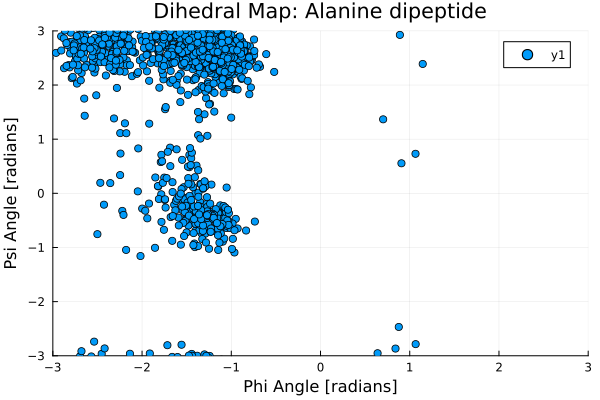

In [91]:
# k = 1のプロット
k = 5
phi = map(x -> x[1], data_k[k])
psi = map(x -> x[2], data_k[k])
plot(phi[1:10:end], psi[1:10:end], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

### ΔFを求める

In [14]:
kBT = 0.1
beta = 1.0/(kBT)
nstep = size(phi, 1)

#FとF_targetを計算
@show F = compute_free_energy(phi, psi, beta, theta_zero, n, k)
@show F_target = compute_free_energy(phi_target, psi_target, beta, theta_zero_target, n_target, k_target)

@show y_train = F_target - F #自由エネルギー差

#EXPを用いて自由エネルギー差を推定
U_array = [sum_compute_dihedral_energy(phi[i], theta_zero, n, k) + sum_compute_dihedral_energy(psi[i], theta_zero, n, k) for i in 1:N]
@show deltaF = compute_deltaF(phi, psi, beta, theta_zero_target, n_target, k_target, U_array)

F = compute_free_energy(phi, psi, beta, theta_zero, n, k) = 0.24844494282322316
F_target = compute_free_energy(phi_target, psi_target, beta, theta_zero_target, n_target, k_target) = 7.049411581770065
y_train = F_target - F = 6.800966638946842
deltaF = compute_deltaF(phi, psi, beta, theta_zero_target, n_target, k_target, U_array) = -12.52801115795781


-12.52801115795781

### 勾配法で訓練してkを推定

In [15]:
X_train = phi, psi

([-1.1155004501342773, -2.600269317626953, -1.3151869773864746, -1.4829646348953247, -2.5150694847106934, -1.251499056816101, -0.9836890697479248, -1.3160641193389893, -1.3205173015594482, -1.6116554737091064  …  -1.5146130323410034, -1.5577037334442139, -1.7684531211853027, -1.3829153776168823, -1.5279468297958374, -1.0845167636871338, -1.3248342275619507, -1.3197063207626343, -1.448112964630127, -1.2685145139694214], [-1.722288727760315, 0.19221410155296326, -0.7502973079681396, -0.6886612772941589, 1.071189045906067, 2.269709348678589, 2.9160468578338623, 1.8314296007156372, 2.2721915245056152, 1.5454579591751099  …  2.9620132446289062, 1.6588149070739746, 2.3495211601257324, 2.2016406059265137, 2.6058993339538574, 2.616703510284424, 2.811122417449951, 1.481923222541809, 2.650815725326538, 2.207899570465088])

In [16]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(phi_array, psi_array, beta, theta_zero_array, n_array, U_array) = compute_deltaF(phi_array, psi_array, beta, theta_zero_array, n_array, m.P, U_array)

In [17]:
# Sanity check
m = Energy(k_target)
loss(X, y) = Flux.Losses.mse(m(X[1],X[2], beta, theta_zero, n, U_array), y)
loss(X_train, y_train)

373.60938267323303

In [18]:
#initial parameter
m = Energy(copy(k))
loss(X_train, y_train)

679.0725286653113

In [19]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2)

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [20]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [21]:
loss_train = []
nepoch = 1000
println("Initial loss: $(loss(X_train, y_train))")
println("Initial param: $(ps[1])")
for epoch in 1:nepoch
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    if (epoch % (nepoch / 10) == 0)
        print_callback(epoch, L, ps)
    end
end

Initial loss: 679.0725286653113
Initial param: [-2.0, 5.0, 2.2722793075263983, 0.33249158784820976, -1.0]
Epoch: 100, loss: 606.0557269208873
param: [-1.0111292921223074, 4.009378140173791, 1.281240098907692, 1.3221710550344836, -1.9910989513276942]
Epoch: 200, loss: 540.0155907389208
param: [-0.05353606387762251, 3.0449248445801134, 0.31516236905812345, 2.2829414423270586, -2.9574088862216295]
Epoch: 300, loss: 480.52861255485055
param: [0.8723059224696337, 2.1066924880074542, -0.6259814331583081, 3.2145410527092855, -3.8989681625521886]
Epoch: 400, loss: 427.1001208051255
param: [1.7668856683759684, 1.1939018437191504, -1.5430163073075678, 4.11761306616396, -4.816607621825872]
Epoch: 500, loss: 379.25775557542886
param: [2.630723716626363, 0.305730360908912, -2.436810446367031, 4.9928404329065925, -5.711201206358303]
Epoch: 600, loss: 336.5507871189491
param: [3.46438423617041, -0.5586968973966591, -3.3082833973939394, 5.840956779941264, -6.583673988888776]
Epoch: 700, loss: 298.5496

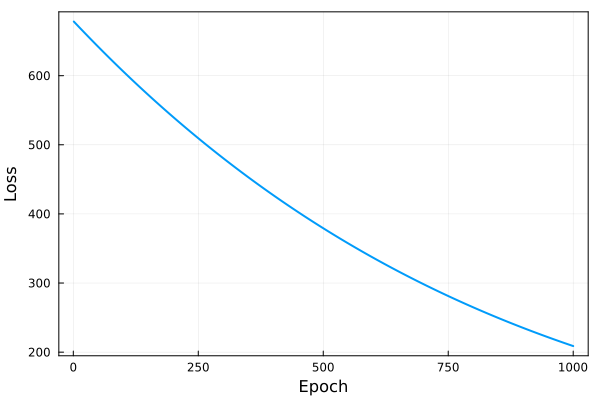

In [22]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [23]:
println("Initial k:   ", k)
println("Estimated k: ", m.P)
println("Target k:    ", k_target)

Initial k:   [-2.0, 5.0, 2.2722793075263983, 0.33249158784820976, -1.0]
Estimated k: [6.510725184665447, -3.798737946146371, -6.591534232982768, 8.979329250727835, -9.873022212901043]
Target k:    [-0.1396954369058983, 1.4020721749174487, 2.2722793075263983, 0.33249158784820976, 1.669819011164073]
